In [1]:
import pandas as pd
from RoutePlanner.CellGrid import CellGrid
from matplotlib import pyplot as plt
import xarray as xr
import netCDF4 as nc
import datetime
from RoutePlanner.TemporalCellGrid import TemporalCellGrid
import matplotlib.pyplot as plt
from RoutePlanner.CellBox import CellBox
import math

In [2]:
def loadIce(icePointsPath, startTime, endTime):
    icePoints = xr.open_dataset(icePointsPath)
    ipSlice = icePoints.sel(time=slice(startTime, endTime))
    ipSlice = ipSlice.to_dataframe()
    
    ipSlice = ipSlice.reset_index()
    ipSlice = ipSlice.rename(columns={'XC':'long', 'YC':'lat', 'Depth':'depth', 'SIarea':'iceArea'})
    ipSlice['long'] = ipSlice['long'].apply(lambda x: x if x <= 180 else x - 360)
  
    return ipSlice

In [3]:
# load current Data
sose = nc.Dataset("data/SOSE_surface_velocity_6yearMean_2005-2010.nc")

currentPoints = pd.DataFrame({'long': sose['lon'][...].data.flatten(),
                                'lat': sose['lat'][...].data.flatten(),
                                'uC': sose['uC'][...].data.flatten(),
                                'vC': sose['vC'][...].data.flatten()})

currentPoints['time'] = ''
currentPoints['uC'] = currentPoints['uC'] * 3.6
currentPoints['vC'] = currentPoints['vC'] * 3.6
currentPoints['long'] = currentPoints['long'].apply(lambda x: x if x <= 180 else x - 360)

print(currentPoints)

            long        lat        uC        vC time
0       0.083333 -77.874969       NaN       NaN     
1       0.250000 -77.874969       NaN       NaN     
2       0.416667 -77.874969       NaN       NaN     
3       0.583333 -77.874969       NaN       NaN     
4       0.750000 -77.874969       NaN       NaN     
...          ...        ...       ...       ...  ...
691195 -0.750000 -24.708300  0.002377 -0.122380     
691196 -0.583313 -24.708300  0.002553 -0.119374     
691197 -0.416656 -24.708300  0.002715 -0.116243     
691198 -0.250000 -24.708300  0.002877 -0.112676     
691199 -0.083313 -24.708300  0.002877 -0.108961     

[691200 rows x 5 columns]


In [4]:
modis_ips = pd.read_csv('Modis_1km.csv')
modis_ips = modis_ips.rename(columns ={'0':'long', '1':'lat', '2':'time', '3':'iceArea', '4':'cloud'})
modis_ips['iceArea'] = modis_ips['iceArea'] * 0.1 # Modis classification set at 0-10, bsose 0-1. Tranformation done for equivilancy

print(modis_ips)

          Unnamed: 0       long        lat        time  iceArea  cloud
0                  0 -65.001709 -59.998535  19-02-2017      0.9      1
1                  1 -64.992920 -59.998535  19-02-2017      0.9      1
2                  2 -64.984131 -59.998535  19-02-2017      0.9      1
3                  3 -64.975342 -59.998535  19-02-2017      0.9      1
4                  4 -64.966553 -59.998535  19-02-2017      0.9      1
...              ...        ...        ...         ...      ...    ...
14243203    14243203 -10.043701 -79.993652  19-02-2017      0.5      0
14243204    14243204 -10.034912 -79.993652  19-02-2017      0.5      0
14243205    14243205 -10.026123 -79.993652  19-02-2017      0.5      0
14243206    14243206 -10.017334 -79.993652  19-02-2017      0.5      0
14243207    14243207 -10.008545 -79.993652  19-02-2017      0.4      0

[14243208 rows x 6 columns]


In [5]:
cloud_count = modis_ips[modis_ips.cloud == 1].shape[0]
no_cloud_count = modis_ips[modis_ips.cloud == 0].shape[0]
print("Cloud_Percentage: " +  str((cloud_count / modis_ips.shape[0]) * 100))
print("No_Cloud_Percentage: " + str((no_cloud_count / modis_ips.shape[0]) * 100))
print("Total Clouds: " + str(modis_ips.shape[0]))

Cloud_Percentage: 40.67468508498928
No_Cloud_Percentage: 59.32531491501072
Total Clouds: 14243208


In [6]:
modis_ips = modis_ips[modis_ips.cloud != 1] # datapoints marked covered by cloud removed.

modis_ips = modis_ips.drop(columns = ['Unnamed: 0', 'cloud']) # remove unused columns

In [7]:
icePointsPath = "data/bsose_i122_2013to2017_1day_SeaIceArea.nc"

startTime = '2017-02-19'
endTime = '2017-02-19'

bsose = loadIce(icePointsPath, startTime, endTime)  # load in BSOSE for bathemetry
bsose = bsose.drop(columns = ['iter', 'rA', 'iceArea'])  # drop unsued columns
print(bsose)

              time      long        lat        depth
0       2017-02-19  0.083333 -77.982651     0.000000
1       2017-02-19  0.083333 -77.947899     0.000000
2       2017-02-19  0.083333 -77.913048     0.000000
3       2017-02-19  0.083333 -77.878098     0.000000
4       2017-02-19  0.083333 -77.843056     0.000000
...            ...       ...        ...          ...
1270075 2017-02-19 -0.083313 -30.305382  4520.000000
1270076 2017-02-19 -0.083313 -30.161386  4287.402832
1270077 2017-02-19 -0.083313 -30.017181  4520.000000
1270078 2017-02-19 -0.083313 -29.870987  4798.514648
1270079 2017-02-19 -0.083313 -29.715317  4736.891602

[1270080 rows x 4 columns]


In [8]:
latMin = -80
latMax = -60
longMin = -65
longMax = -10

cellWidth = 5
cellHeight = 2.5

modis_grid = CellGrid(longMin, longMax, latMin, latMax, cellWidth, cellHeight)
modis_grid.addIcePoints(modis_ips)
modis_grid.addCurrentPoints(currentPoints)
modis_grid.addDataPoints(bsose)

cellBoxArea: 30017.32287648972
icePoints: 161596
icePoints per Km^2: 5.38342478657768


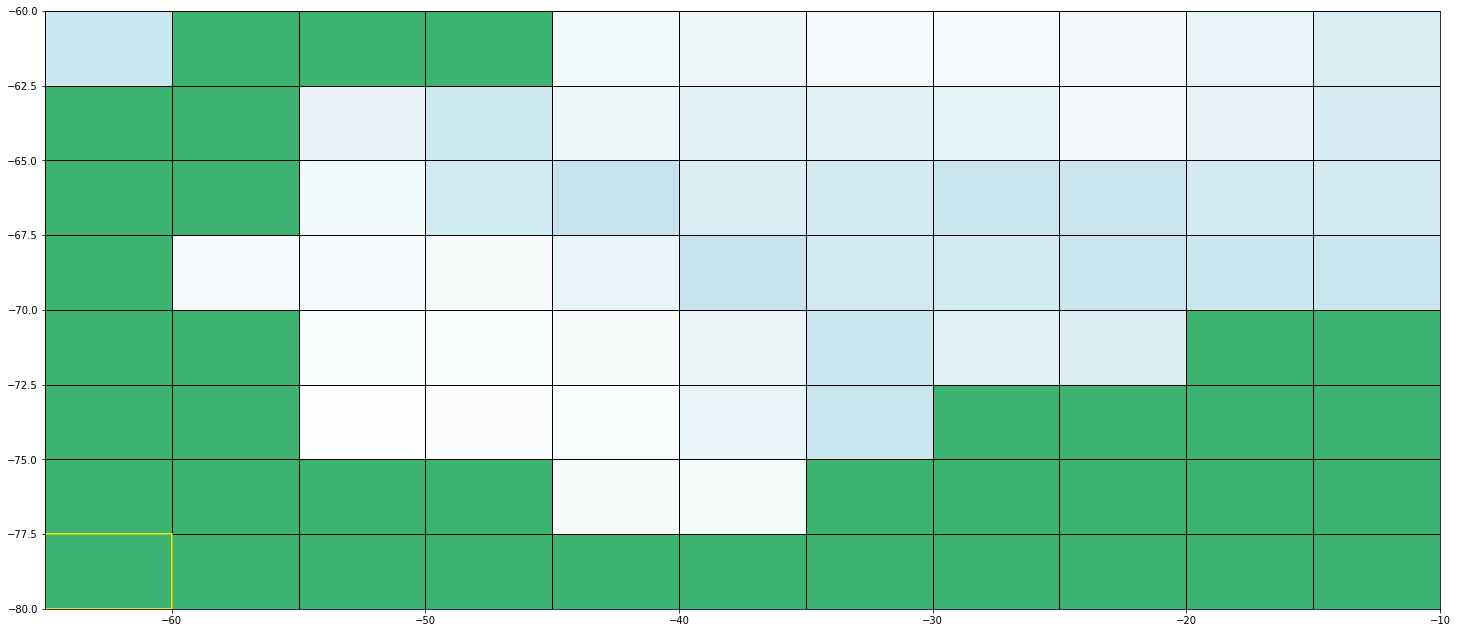

In [9]:
cellBox = modis_grid.cellBoxes[0]
icePoints = cellBox.getDataPoints().dropna(subset = ['iceArea'])
modis_grid.plot(highlightCellBoxes =  {'yellow':{cellBox}})

"""
Latitude: 1 deg = 110.574 km
Longitude: 1 deg = 111.320*cos(latitude) km
"""

cellBoxHeightKm = cellBox.height * 110.574
cellBoxWidthKm = cellBox.width * 111.320 * math.cos(math.radians(cellBox.lat + (0.5 * cellBox.height)))

cellBoxAreaKm = cellBoxHeightKm * cellBoxWidthKm

print("cellBoxArea: "  + str(cellBoxAreaKm))
print("icePoints: " + str(icePoints.shape[0]))

print("icePoints per Km^2: " + str(icePoints.shape[0] / cellBoxAreaKm))

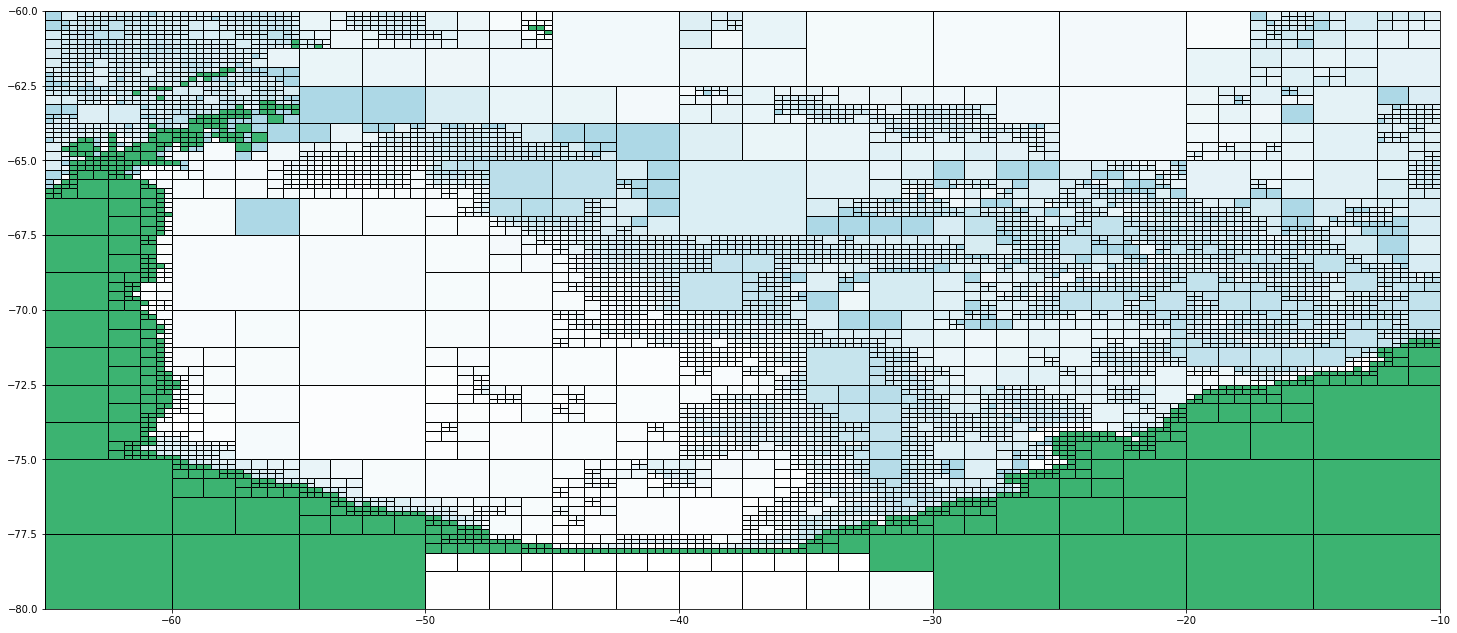

In [10]:
splittingPercentage = 0.35 # thershold
splitMinProp = 0.3 # lowerbound
splitMaxProp = 1.0 # upperbound

modis_grid.iterativeSplit(4, splittingPercentage, splitMinProp, splitMaxProp)
modis_grid.plot()

In [11]:
minimum_ice_points = 1

cellBoxes_under_minimum = []

for cellBox in modis_grid.cellBoxes:
    if isinstance(cellBox, CellBox):
        icePoints = cellBox.getDataPoints().dropna(subset = ['iceArea'])
        if icePoints.shape[0] < minimum_ice_points:
            cellBoxes_under_minimum.append(cellBox)
            
print(len(cellBoxes_under_minimum))


304


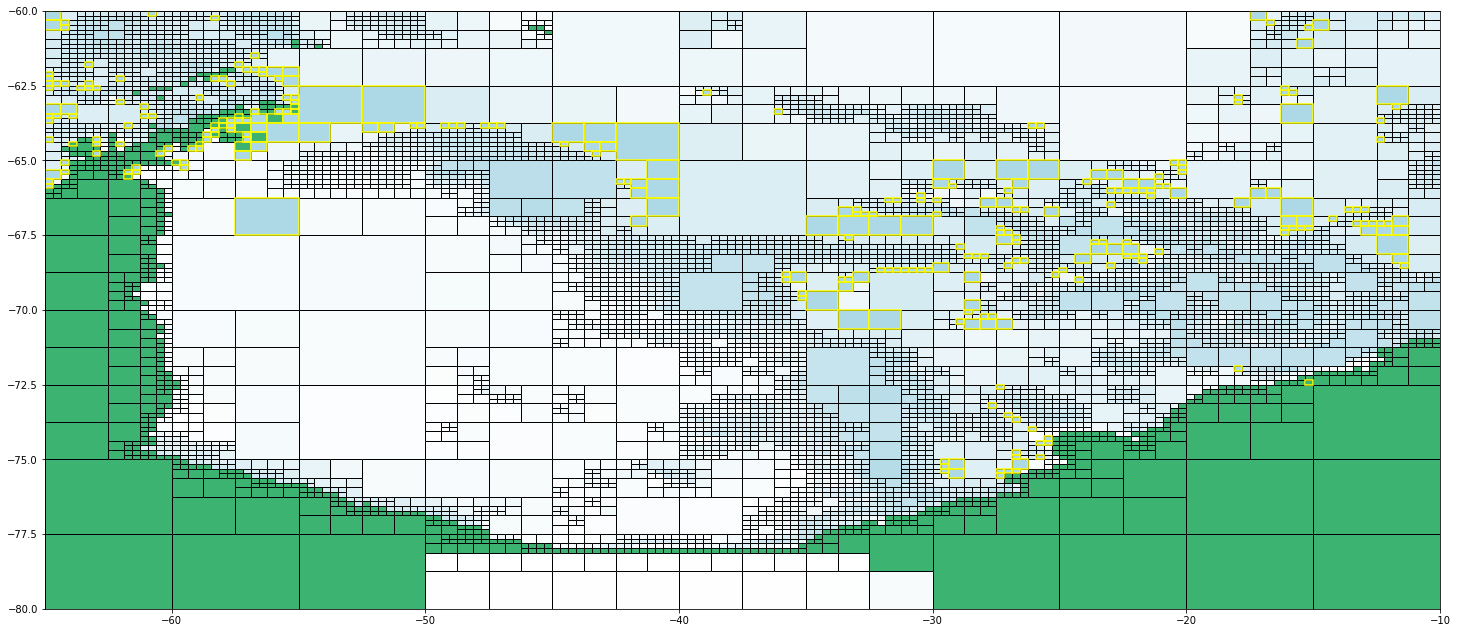

In [12]:
modis_grid.plot(highlightCellBoxes = {'yellow':cellBoxes_under_minimum})

In [41]:
minimum_ips_km2 = 0.2

cellBoxes_under_minimum = []

for cellBox in modis_grid.cellBoxes:
    if isinstance(cellBox, CellBox):
        icePoints = cellBox.getDataPoints().dropna(subset = ['iceArea'])
        
        cellBoxHeightKm = cellBox.height * 110.574
        cellBoxWidthKm = cellBox.width * 111.320 * math.cos(math.radians(cellBox.lat + (0.5 * cellBox.height)))
        cellBoxAreaKm = cellBoxHeightKm * cellBoxWidthKm
        
        ips_per_km2 = icePoints.shape[0] / cellBoxAreaKm
        
        if ips_per_km2 < minimum_ips_km2:
            cellBoxes_under_minimum.append(cellBox)
            
print(len(cellBoxes_under_minimum))

1120


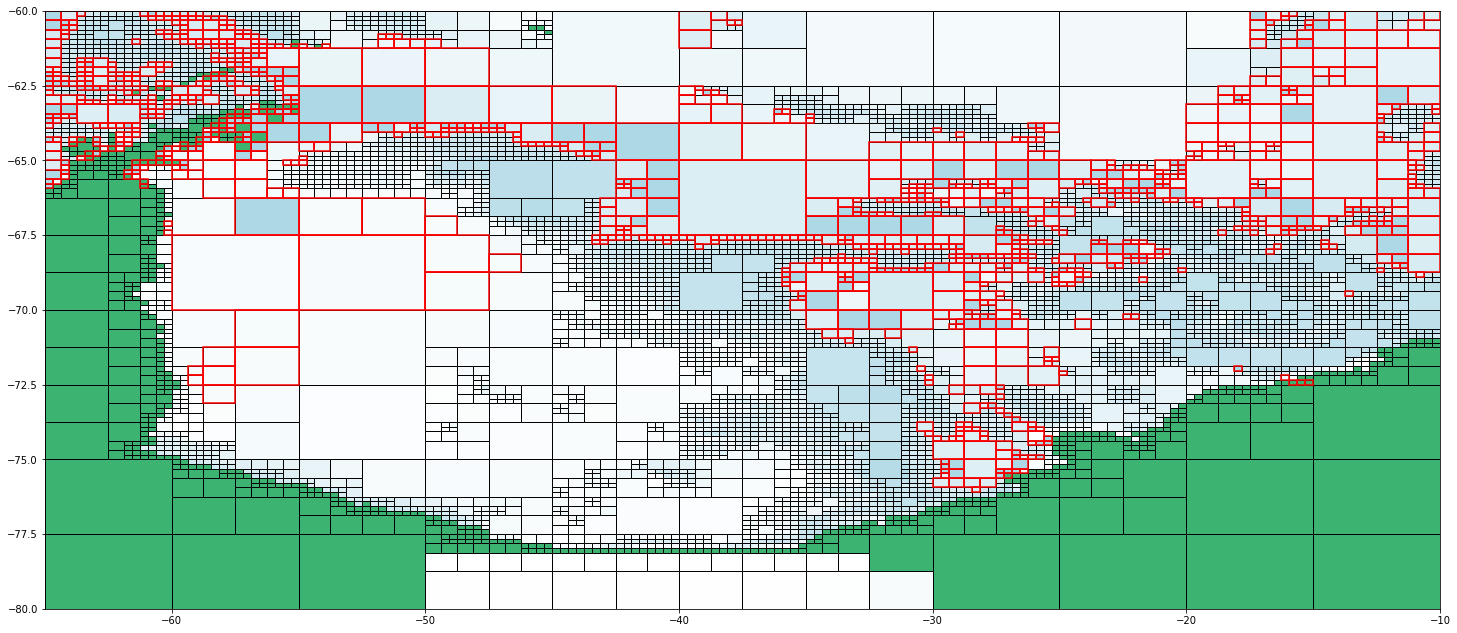

In [42]:
modis_grid.plot(highlightCellBoxes = {"red":cellBoxes_under_minimum})

In [21]:
iceThershold = 0.8
cellsOverBound = []

for cellBox in modis_grid.cellBoxes:
    if isinstance(cellBox, CellBox):
        if cellBox.iceArea() >= iceThershold:
            cellsOverBound.append(cellBox)

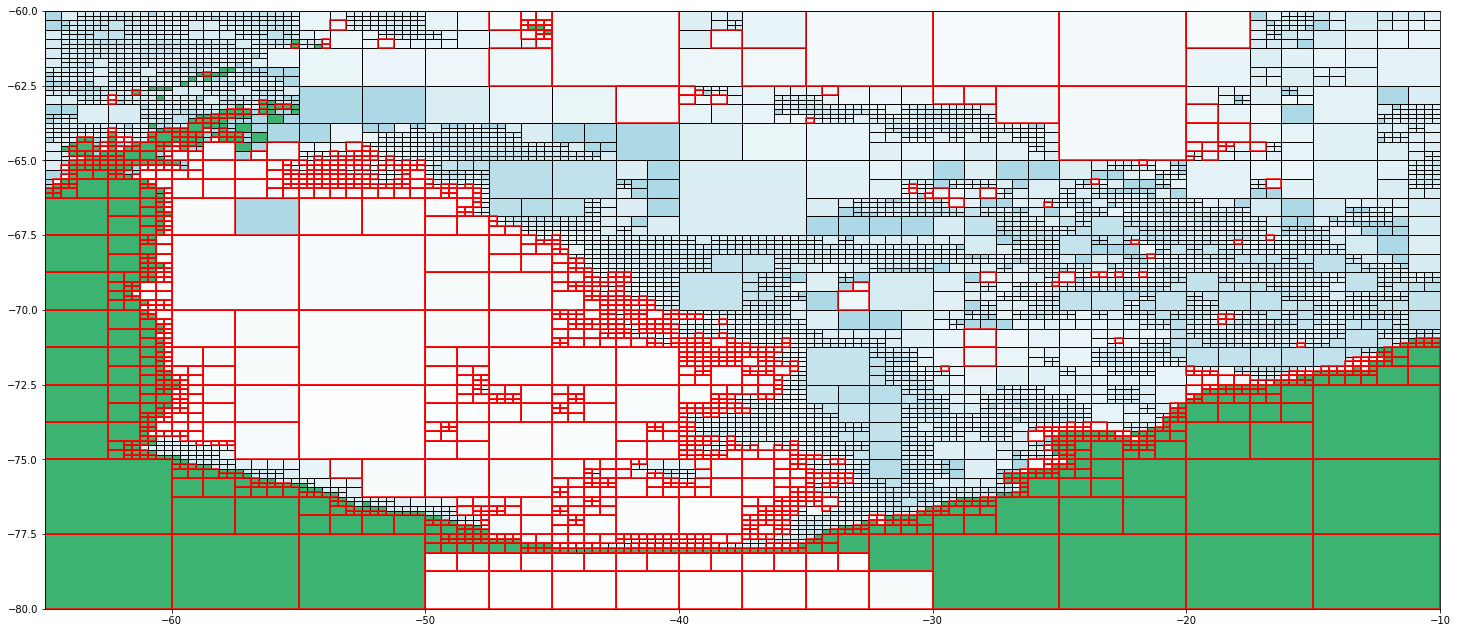

In [23]:
modis_grid.plot(highlightCellBoxes = {"red":cellsOverBound})

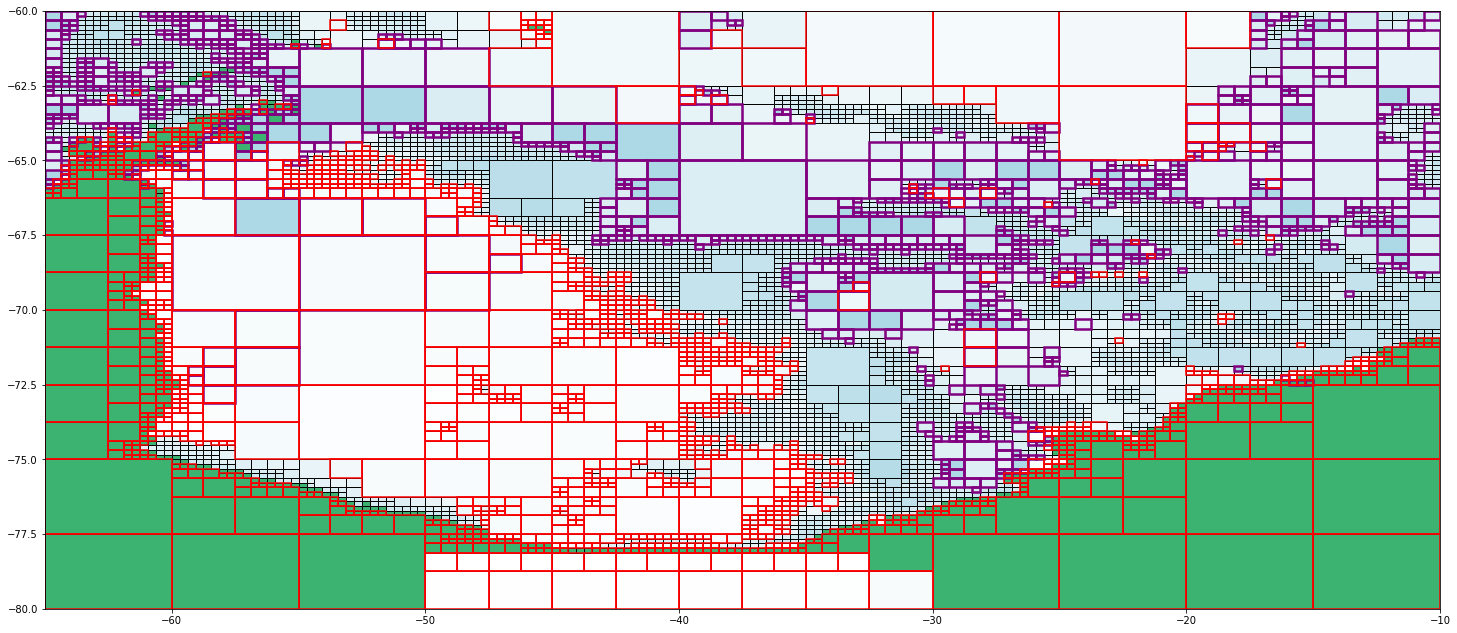

In [18]:
modis_grid.plot(highlightCellBoxes = {"purple":cellBoxes_under_minimum, 
                                     "red": cellsOverBound})

In [ ]:
cellBox = modis_grid.getCellBox(-51, -74)[0]
modis_grid.plot(highlightCellBoxes = {cellBox})
print(cellBox.getDataPoints())

In [ ]:
icePoints = cellBox.getDataPoints().dropna(subset = ['iceArea'])
propOver = icePoints.loc[icePoints['iceArea'] > splittingPercentage]
#print(icePoints)
print(propOver.shape[0]/ icePoints.shape[0])

In [ ]:
latMin = -77.5
latMax = -70
longMin = -65
longMax = -50

cellWidth = 5
cellHeight = 2.5

modis_grid = CellGrid(longMin, longMax, latMin, latMax, cellWidth, cellHeight)
modis_grid.addIcePoints(modis_ips)
modis_grid.addCurrentPoints(currentPoints)
modis_grid.addDataPoints(bsose)

In [ ]:
splittingPercentage = 0.35 # thershold
splitMinProp = 0.3 # lowerbound
splitMaxProp = 1.0 # upperbound

#modis_grid.iterativeSplit(4, splittingPercentage, splitMinProp, splitMaxProp)
modis_grid.plot()

In [ ]:
modis_grid.iterativeSplit(6, splittingPercentage, splitMinProp, splitMaxProp)
modis_grid.plot()

In [ ]:
latMin = -77.5
latMax = -70
longMin = -40
longMax = -20

cellWidth = 5
cellHeight = 2.5

modis_grid = CellGrid(longMin, longMax, latMin, latMax, cellWidth, cellHeight)
modis_grid.addIcePoints(modis_ips)
modis_grid.addCurrentPoints(currentPoints)
modis_grid.addDataPoints(bsose)

In [ ]:
modis_grid.plot()

In [ ]:
modis_grid.iterativeSplit(6, splittingPercentage, splitMinProp, splitMaxProp)
modis_grid.plot()

In [ ]:
cellBox = modis_grid.cellBoxes[431]
modis_grid.plot(highlightCellBoxes = {cellBox})

In [ ]:
print(cellBox.getDataPoints())

In [ ]:
iceThershold = 0.8
cellsOverBound = []

for cellBox in modis_grid.cellBoxes:
    if isinstance(cellBox, CellBox):
        if cellBox.iceArea() >= iceThershold:
            cellsOverBound.append(cellBox)
        
print(len(cellsOverBound))

In [ ]:
modis_grid.plot(highlightCellBoxes = cellsOverBound)

In [ ]:
cellBox = modis_grid.getCellBox(-39, -66)[0]
modis_grid.plot(highlightCellBoxes = {cellBox})

In [ ]:
icePoints = cellBox.getIcePoints()
print(icePoints['iceArea'].mean())

In [ ]:
print(icePoints[icePoints.iceArea > splittingPercentage].shape[0] / icePoints.shape[0])